In [5]:
%load_ext autoreload
%autoreload 2

In [5]:
from dcase_evaluator import DCASEEvaluator
from models.audiosep import AudioSep
from models.one_peace_encoder import ONE_PEACE_Encoder

import argparse
import os
from utils import parse_yaml, load_ss_model
import torch
import numpy as np

import librosa
import pandas as pd
import soundfile as sf
import scipy.io.wavfile as wf
from scipy.io import wavfile
from scipy.signal import spectrogram
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils import calculate_sdr, calculate_sisdr

In [3]:
df = pd.read_csv('lass_synthetic_validation.csv')
df = df.assign(sdr=None, sisdr=None, sdri = None)
df.head()

source               noise   snr  \
0  692211_12333864-hq   701692_6014995-hq    10   
1  692211_12333864-hq  708399_14710576-hq     1   
2  692211_12333864-hq  708360_14781196-hq   -13   
3  699830_15175263-hq   692865_2250422-hq    -6   
4  699830_15175263-hq   695808_5812781-hq    10   

                                             caption   sdr sisdr  sdri  
0  Someone is playing a kind of musical instrumen...  None  None  None  
1  Someone is playing the musical instrument, whi...  None  None  None  
2  The musical instrument is producing buzzing so...  None  None  None  
3  There are some motorcycles and cars on the roa...  None  None  None  
4  A race car engine roars as it accelerates and ...  None  None  None

In [4]:
validation_csv = 'lass_synthetic_validation.csv'
# dict_eval = pd.read_csv(validation_csv).set_index('file_name').to_dict()['caption']
output_dir = 'lass_evaluation_real_output'
audio_dir = 'lass_validation'
sampling_rate = 16000

In [ ]:
# # Calculate SDR
# def calculate_sdr(ref, est):
#     ref = np.array(ref)
#     est = np.array(est)
#     # estimated signal onto reference projection
#     a = np.dot(ref, est) / np.dot(ref, ref)
#     proj = a * ref
#     # error between estimated and projected signals
#     error = est - proj
#     # compute sdr
#     sdr = 10 * np.log10(np.sum(proj**2) / np.sum(error**2))
#     return sdr

# # Calculate SI-SDR
# def calculate_si_sdr(ref, est):
#     ref = np.array(ref)
#     est = np.array(est)
#     # normalize signals to remove scale dependency
#     ref_energy = np.dot(ref, ref)
#     scaling_factor = np.dot(ref, est) / ref_energy
#     proj = scaling_factor * ref
#     # error between estimated and projected signals
#     error = est - proj
#     # compute si-sdr
#     si_sdr = 10 * np.log10(np.sum(proj**2) / np.sum(error**2))
#     return si_sdr

In [ ]:
# testing for 1st row
# source1 = '692211_12333864-hq.wav'
# noise1 = '701692_6014995-hq.wav'
# source1_lib, sr = librosa.load(f"{audio_dir}/{source1}", sr=sampling_rate)
# noise1_lib, sr = librosa.load(f"{audio_dir}/{noise1}", sr=sampling_rate)
# mixture1 = source1_lib + (noise1_lib * 2)
# calculate_sdr(source1_lib, mixture1), calculate_si_sdr(source1_lib, mixture1)

In [ ]:
# for index, row in df.iterrows():
#     source, sr = librosa.load(f"{audio_dir}/{row['source']}.wav", sr=sampling_rate)
#     noise, _ = librosa.load(f"{audio_dir}/{row[' noise']}.wav", sr=sampling_rate)
#     mixture = source + noise
#     df.at[index, 'sdr'] = calculate_sdr(source, mixture)
#     df.at[index, 'sisdr'] = calculate_si_sdr(source, mixture)
# df    

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config_yaml = 'config/audiosep_onepeace.yaml'
encoder_checkpoint_path = '/fs/nexus-scratch/vla/finetune_al_retrieval.pt'

# NOTE: best checkpoint on validation set
ssnet_checkpoint_path = '/fs/nexus-scratch/vla/checkpoints/train/audiosep_onepeace,devices=1/step=140000.ckpt'
sampling_rate=1600
configs = parse_yaml(config_yaml)

# ONE_PEACE modelhub expects some paths to be relative to this dir
os.chdir('ONE-PEACE/')
# TODO:path in shared scratch dir for now..., move to class project dir whenever we get that
query_encoder = ONE_PEACE_Encoder(pretrained_path=encoder_checkpoint_path)
os.chdir('..')

# put ONE-PEACE model in eval model (probably unecessary)
query_encoder.model.model.eval()

pl_model = load_ss_model(
    configs=configs,
    checkpoint_path=ssnet_checkpoint_path,
    query_encoder=query_encoder
).to(device)

/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/fairseq/checkpoint_utils.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f, m

In [ ]:

gather = []
with torch.no_grad():
    # iterate through dataframe
    for index, row in df.iterrows():
        # source file name (.wav file)

        text = row['caption']
        
        filename = row['source']
        file_path = os.path.join(audio_dir, f'{filename}.wav')
        
        # load audio from test set
        input_path = os.path.join(audio_dir, filename)
        source, fs = librosa.load(input_path, sr=sampling_rate, mono=True)

        # compute text embedding with ONE-PEACE query encoder
        conditions = pl_model.query_encoder.get_query_embed(
                        modality='text',
                        text=[text],
                        device=device 
        )

        input_dict = {
                        "mixture": torch.Tensor(source)[None, None, :].to(device),
                        "condition": conditions,
                    } 

        # output audio
        sep_segment = pl_model.ss_model(input_dict)["waveform"]

        # TODO: compute ONE-PEACE embedding on sep_segment and dot w/ conditions for comparison in embedding space
        # sep_segment_embd = pl_model.query_encoder.model
        # sep_segment: (batch_size=1, channels_num=1, segment_samples)
        sep_segment = sep_segment.squeeze(0).squeeze(0).data.cpu().numpy()


        # write out .wav file
        output_path = os.path.join(output_dir, filename)
        # wf.write(output_path, sampling_rate, sep_segment)

        sdr_no_sep = calculate_sdr(ref=source, est=mixture)
        sdr = calculate_sdr(ref=source, est=sep_segment)
        sdri = sdr - sdr_no_sep
        sisdr = calculate_sisdr(ref=source, est=sep_segment)


        similarities = dict(
            filename = filename
        )

        # COMPUTE SIMILARITIES
        src_audios, audio_padding_masks = pl_model.query_encoder.model.process_audio([input_path])
        audio_features = pl_model.query_encoder.model.extract_audio_features(src_audios, audio_padding_masks)
        input_similarity =l conditions @ audio_features.T
        similarities['input_similarity'] = input_similarity.squeeze(0).cpu().numpy()[0]
        # print(f'Text Prompt - Mixed Audio Input Similarity: {input_similarity}')

        src_audios, audio_padding_masks = pl_model.query_encoder.model.process_audio([output_path])
        audio_features = pl_model.query_encoder.model.extract_audio_features(src_audios, audio_padding_masks)
        output_similarity = conditions @ audio_features.T
        similarities['output_similarity'] = output_similarity.squeeze(0).cpu().numpy()[0]
        # print(f'Text Prompt - Seperated Audio Output Similarity: {output_similarity}')

        gather.append(similarities)


In [1]:
from dcase_evaluator_analysis import DCASEEvaluatorAnalysis
from models.audiosep import AudioSep
from models.one_peace_encoder import ONE_PEACE_Encoder

import argparse
import os
from utils import parse_yaml, load_ss_model

def eval(evaluator,
         encoder_checkpoint_path = None, 
         ssnet_checkpoint_path = None, 
         config_yaml=None, 
         device = "cuda"):
    
    configs = parse_yaml(config_yaml)
    
    # ONE_PEACE modelhub expects some paths to be relative to this dir
    os.chdir('ONE-PEACE/')
    # TODO:path in shared scratch dir for now..., move to class project dir whenever we get that
    query_encoder = ONE_PEACE_Encoder(pretrained_path=encoder_checkpoint_path)
    os.chdir('..')

    # put ONE-PEACE model in eval model (probably unecessary)
    query_encoder.model.model.eval()

    pl_model = load_ss_model(
        configs=configs,
        checkpoint_path=ssnet_checkpoint_path,
        query_encoder=query_encoder
    ).to(device)


    print(f'-------  Start Evaluation  -------')

    # evaluation 
    return evaluator(pl_model)
    msg_clotho = "SDR: {:.3f}, SDRi: {:.3f}, SISDR: {:.3f}".format(SDR, SDRi, SISDR)
    print(msg_clotho)

    print('-------------------------  Done  ---------------------------')



/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfshomes/vla/lass-final-project/models/CLAP/open_clip/factory.py:55: FutureWarning: You a

In [2]:


parser = argparse.ArgumentParser()
parser.add_argument(
    "--config_yaml",
    type=str,
    required=True,
    help="Path of config file for AudioSep model",
)

parser.add_argument(
    "--encoder_checkpoint_path",
    type=str,
    required=True,
    help="Path of pretrained checkpoint for QueryEncoder (ONE-PEACE)",
)

parser.add_argument(
    '--ssnet_checkpoint_path',
    type=str,
    required=True,
    help = "Path of pretrained checkpoint for Seperation Network (ResUNet)"
)

cli = '--config_yaml config/audiosep_onepeace.yaml --encoder_checkpoint_path /fs/nexus-scratch/vla/finetune_al_retrieval.pt  --ssnet_checkpoint_path /fs/nexus-scratch/vla/checkpoints/train/audiosep_onepeace,devices=1/step=140000.ckpt'

args = parser.parse_args(cli.split())
args



Namespace(config_yaml='config/audiosep_onepeace.yaml', encoder_checkpoint_path='/fs/nexus-scratch/vla/finetune_al_retrieval.pt', ssnet_checkpoint_path='/fs/nexus-scratch/vla/checkpoints/train/audiosep_onepeace,devices=1/step=140000.ckpt')

In [3]:

dcase_evaluator = DCASEEvaluatorAnalysis(
    sampling_rate=16000,
    eval_indexes='lass_synthetic_validation.csv',
    audio_dir='lass_validation',
)

# checkpoint_path=
df_results = eval(dcase_evaluator,
                  encoder_checkpoint_path = args.encoder_checkpoint_path,
                  ssnet_checkpoint_path = args.ssnet_checkpoint_path,
                  config_yaml = args.config_yaml,
                  device = "cuda")


/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/fairseq/checkpoint_utils.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f, m

-------  Start Evaluation  -------
Evaluation on DCASE T9 synthetic validation set.


100%|██████████| 3000/3000 [18:05<00:00,  2.76it/s]


In [4]:
df_results

source_path  \
0     lass_validation/692211_12333864-hq.wav   
1     lass_validation/692211_12333864-hq.wav   
2     lass_validation/692211_12333864-hq.wav   
3     lass_validation/699830_15175263-hq.wav   
4     lass_validation/699830_15175263-hq.wav   
...                                      ...   
2995   lass_validation/688466_1089955-hq.wav   
2996   lass_validation/688466_1089955-hq.wav   
2997   lass_validation/689376_9034501-hq.wav   
2998   lass_validation/689376_9034501-hq.wav   
2999   lass_validation/689376_9034501-hq.wav   

                                  noise_path  \
0      lass_validation/701692_6014995-hq.wav   
1     lass_validation/708399_14710576-hq.wav   
2     lass_validation/708360_14781196-hq.wav   
3      lass_validation/692865_2250422-hq.wav   
4      lass_validation/695808_5812781-hq.wav   
...                                      ...   
2995  lass_validation/708454_12590268-hq.wav   
2996  lass_validation/684674_14902390-hq.wav   
2997   lass_validation/688121_4912242-hq.wav   
2998  lass_validation/706280_11191534-hq.wav   
2999   lass_validation/688781_9177297-hq.wav   

                                             input_path  \
0     lass_validation_output/('692211_12333864-hq.wa...   
1     lass_validation_output/('692211_12333864-hq.wa...   
2     lass_validation_output/('692211_12333864-hq.wa...   
3     lass_validation_output/('699830_15175263-hq.wa...   
4     lass_validation_output/('699830_15175263-hq.wa...   
...                                                 ...   
2995  lass_validation_output/('688466_1089955-hq.wav...   
2996  lass_validation_output/('688466_1089955-hq.wav...   
2997  lass_validation_output/('689376_9034501-hq.wav...   
2998  lass_validation_output/('689376_9034501-hq.wav...   
2999  lass_validation_output/('689376_9034501-hq.wav...   

                                            output_path  \
0     lass_validation_output/('692211_12333864-hq.wa...   
1     lass_validation_output/('692211_12333864-hq.wa...   
2     lass_validation_output/('692211_12333864-hq.wa...   
3     lass_validation_output/('699830_15175263-hq.wa...   
4     lass_validation_output/('699830_15175263-hq.wa...   
...                                                 ...   
2995  lass_validation_output/('688466_1089955-hq.wav...   
2996  lass_validation_output/('688466_1089955-hq.wav...   
2997  lass_validation_output/('689376_9034501-hq.wav...   
2998  lass_validation_output/('689376_9034501-hq.wav...   
2999  lass_validation_output/('689376_9034501-hq.wav...   

                          input_similarity  \
0      [[tensor(0.4017, device='cuda:0')]]   
1      [[tensor(0.3068, device='cuda:0')]]   
2      [[tensor(0.2939, device='cuda:0')]]   
3      [[tensor(0.0607, device='cuda:0')]]   
4      [[tensor(0.3559, device='cuda:0')]]   
...                                    ...   
2995   [[tensor(0.3782, device='cuda:0')]]   
2996   [[tensor(0.2878, device='cuda:0')]]   
2997   [[tensor(0.2429, device='cuda:0')]]   
2998  [[tensor(-0.0364, device='cuda:0')]]   
2999  [[tensor(-0.0595, device='cuda:0')]]   

                        output_similarity      sisdr       sdri        sdr  
0     [[tensor(0.4037, device='cuda:0')]]   9.953128   0.024985  10.024985  
1     [[tensor(0.2847, device='cuda:0')]]   9.277602   8.761090   9.761090  
2     [[tensor(0.3563, device='cuda:0')]]   1.753260  16.971467   3.971467  
3     [[tensor(0.2208, device='cuda:0')]]   5.140363  12.075294   6.075294  
4     [[tensor(0.3880, device='cuda:0')]]  10.268353   0.391239  10.391239  
...                                   ...        ...        ...        ...  
2995  [[tensor(0.3616, device='cuda:0')]]  17.709165   4.720527  17.720528  
2996  [[tensor(0.3146, device='cuda:0')]]   8.886942   0.913530   8.913531  
2997  [[tensor(0.2693, device='cuda:0')]] -13.145703   0.777969 -12.222031  
2998  [[tensor(0.2301, device='cuda:0')]]   9.342722  -1.169885   6.830115  
2999  [[tensor(0.0552, device='cuda:0')]]  -2.153089  16.3000

In [15]:
df_results_parsed = df_results.copy()
df_results_parsed['input_similarity'] = [x.cpu().numpy()[0][0] for x in df_results['input_similarity']]
df_results_parsed['output_similarity'] = [x.cpu().numpy()[0][0] for x in df_results['output_similarity']]

In [20]:
import pandas as pd

In [ ]:
pd.set_option('display.max_colwidth', None)

In [28]:
df_results_parsed.sort_values(by = 'sdr', ascending=False)

source_path  \
2717  lass_validation/688735_10403690-hq.wav   
523   lass_validation/699186_15162327-hq.wav   
762   lass_validation/700237_10996917-hq.wav   
444    lass_validation/692602_6603437-hq.wav   
481    lass_validation/713893_8331855-hq.wav   
...                                      ...   
795    lass_validation/686993_4949349-hq.wav   
1923  lass_validation/707526_14747739-hq.wav   
2296  lass_validation/700314_10996917-hq.wav   
2120   lass_validation/700432_8455865-hq.wav   
2780   lass_validation/712912_5828667-hq.wav   

                                  noise_path  \
2717   lass_validation/687039_2448533-hq.wav   
523    lass_validation/713910_4725336-hq.wav   
762   lass_validation/699245_15101941-hq.wav   
444   lass_validation/707733_14714586-hq.wav   
481    lass_validation/686588_1089955-hq.wav   
...                                      ...   
795   lass_validation/700925_10152894-hq.wav   
1923   lass_validation/707505_1089955-hq.wav   
2296  lass_validation/688686_13854561-hq.wav   
2120   lass_validation/693619_3639801-hq.wav   
2780  lass_validation/697435_15101941-hq.wav   

                                                                                 input_path  \
2717   lass_validation_output/('688735_10403690-hq.wav', '687039_2448533-hq.wav')_input.wav   
523    lass_validation_output/('699186_15162327-hq.wav', '713910_4725336-hq.wav')_input.wav   
762   lass_validation_output/('700237_10996917-hq.wav', '699245_15101941-hq.wav')_input.wav   
444    lass_validation_output/('692602_6603437-hq.wav', '707733_14714586-hq.wav')_input.wav   
481     lass_validation_output/('713893_8331855-hq.wav', '686588_1089955-hq.wav')_input.wav   
...                                                                                     ...   
795    lass_validation_output/('686993_4949349-hq.wav', '700925_10152894-hq.wav')_input.wav   
1923   lass_validation_output/('707526_14747739-hq.wav', '707505_1089955-hq.wav')_input.wav   
2296  lass_validation_output/('700314_10996917-hq.wav', '688686_13854561-hq.wav')_input.wav   
2120    lass_validation_output/('700432_8455865-hq.wav', '693619_3639801-hq.wav')_input.wav   
2780   lass_validation_output/('712912_5828667-hq.wav', '697435_15101941-hq.wav')_input.wav   

                                                                                 output_path  \
2717   lass_validation_output/('688735_10403690-hq.wav', '687039_2448533-hq.wav')_output.wav   
523    lass_validation_output/('699186_15162327-hq.wav', '713910_4725336-hq.wav')_output.wav   
762   lass_validation_output/('700237_10996917-hq.wav', '699245_15101941-hq.wav')_output.wav   
444    lass_validation_output/('692602_6603437-hq.wav', '707733_14714586-hq.wav')_output.wav   
481     lass_validation_output/('713893_8331855-hq.wav', '686588_1089955-hq.wav')_output.wav   
...                                                                                      ...   
795    lass_validation_output/('686993_4949349-hq.wav', '700925_10152894-hq.wav')_output.wav   
1923   lass_validation_output/('707526_14747739-hq.wav', '707505_1089955-hq.wav')_output.wav   
2296  lass_validation_output/('700314_10996917-hq.wav', '688686_13854561-hq.wav')_output.wav   
2120    lass_validation_output/('700432_8455865-hq.wav', '693619_3639801-hq.wav')_output.wav   
2780   lass_validation_output/('712912_5828667-hq.wav', '697435_15101941-hq.wav')_output.wav   

      input_similarity  output_similarity      sisdr       sdri        sdr  
2717          0.294499           0.523779  34.953394  32.872442  34.872441  
523           0.385054           0.464489  31.692014  24.687647  31.687647  
762           0.342787           0.422497  30.516841  21.361416  30.361415  
444           0.160377           0.297836  29.758756  15.754394  29.754393  
481           0.168940           0.185351  29.424593  25.407847  29.407847  
...                ...                ...        ...        ...        ...  
795           0.004782           0.032940 -19.

In [25]:
df_results_parsed.sort_values(by = 'sdr', ascending=False).iloc[0]

source_path                     lass_validation/688735_10403690-hq.wav
noise_path                       lass_validation/687039_2448533-hq.wav
input_path           lass_validation_output/('688735_10403690-hq.wa...
output_path          lass_validation_output/('688735_10403690-hq.wa...
input_similarity                                              0.294499
output_similarity                                             0.523779
sisdr                                                        34.953394
sdri                                                         32.872442
sdr                                                          34.872441
Name: 2717, dtype: object

In [26]:
df_results_parsed.sort_values(by = 'sdr', ascending=False).iloc[0].input_path

"lass_validation_output/('688735_10403690-hq.wav', '687039_2448533-hq.wav')_input.wav"

In [47]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Generate and plot the spectrogram
def plot_spectrograms(mixture, source, sep_segment, sample_rate, name):
    # Load the audio file
    # sample_rate, data = load_wav(file_path)
    
    # Generate spectrogram for mixture source audio
    frequencies, times, Sxx = spectrogram(mixture, fs=sample_rate)
    
    # Plot spectrogram
    plt.figure(figsize=(10, 6))
    source_cmesh = plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma')
    plt.colorbar(label='Power (dB)')
    plt.title('Mixture')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()

    plt.savefig(f'{name}_mixture_spectrogram')
    plt.show()

    vmax = source_cmesh.colorbar.norm.vmax
    vmin = source_cmesh.colorbar.norm.vmin


   #  Generate spectrogram for source audio
    frequencies, times, Sxx = spectrogram(source, fs=sample_rate)
    
    # Plot spectrogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma',
                   vmin=vmin, vmax=vmax)
    
    plt.colorbar(label='Power (dB)')
    plt.title('Target')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig(f'{name}_target_spectrogram')
    plt.show()


    # Generate spectrogram for separated segment output
    frequencies, times, Sxx = spectrogram(sep_segment, fs=sample_rate)
    
    # Plot spectrogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma',
                   vmin=vmin, vmax=vmax)
    
    plt.colorbar(label='Power (dB)')
    plt.title('Separation Result')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig(f'{name}_sep_spectrogram')
    plt.show()

In [ ]:
import librosa
import numpy as np
sampling_rate = 16000
source_path = df_results_parsed.sort_values(by = 'sdr', ascending=False).iloc[0].source_path
mixture_path = df_results_parsed.sort_values(by = 'sdr', ascending=False).iloc[0].input_path
sep_path = df_results_parsed.sort_values(by = 'sdr', ascending=False).iloc[0].output_path

mixture, fs = librosa.load(mixture_path, sr=sampling_rate, mono=True)
source, fs = librosa.load(source_path, sr=sampling_rate, mono=True)
sep_segment, fs = librosa.load(sep_path, sr=sampling_rate, mono=True)

/tmp/ipykernel_622460/2839899522.py:14: RuntimeWarning: divide by zero encountered in log10
  source_cmesh = plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma')


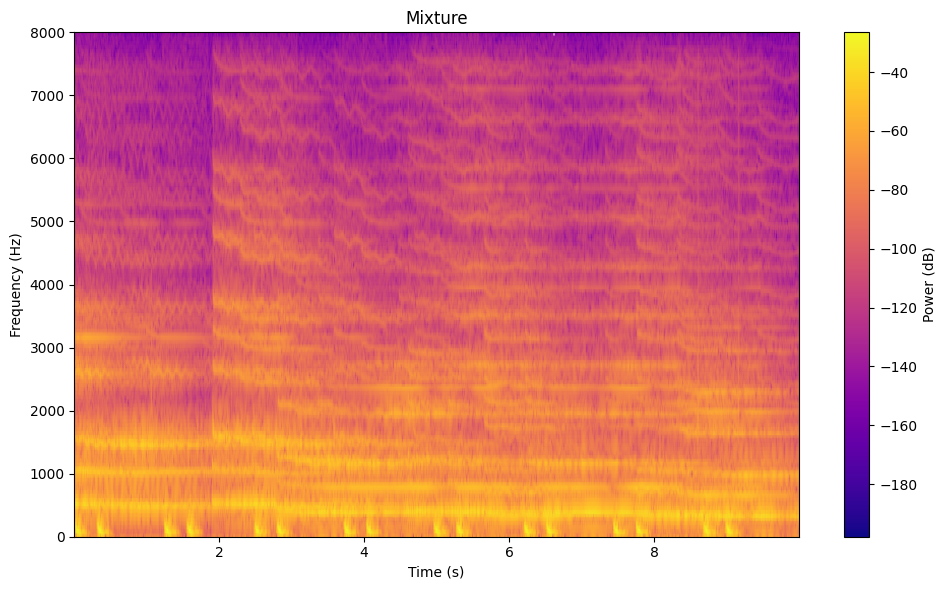

/tmp/ipykernel_622460/2839899522.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma',


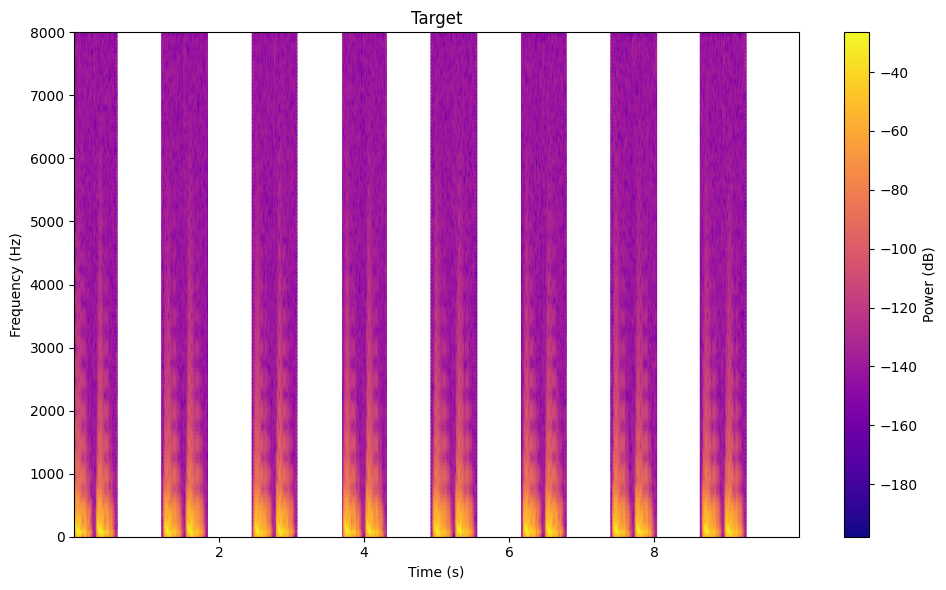

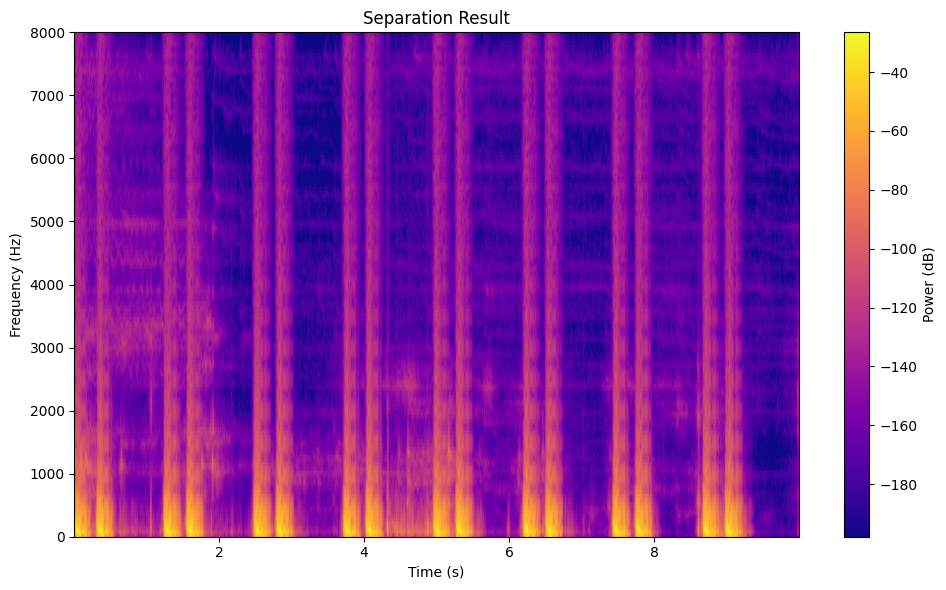

In [ ]:
# 
plot_spectrograms(mixture, source, sep_segment, sampling_rate, 'best_val_sdr')

In [ ]:
# top 1: "Someone is shoveling something, making a clinking sound."
df_results_parsed.sort_values(by = 'sdri', ascending=False)

source_path  \
763   lass_validation/700237_10996917-hq.wav   
1442   lass_validation/707622_1015240-hq.wav   
1995   lass_validation/702285_5828667-hq.wav   
2717  lass_validation/688735_10403690-hq.wav   
1849   lass_validation/689566_7033180-hq.wav   
...                                      ...   
847    lass_validation/707833_8476788-hq.wav   
2941   lass_validation/692865_2250422-hq.wav   
1396  lass_validation/708392_10996917-hq.wav   
796    lass_validation/686993_4949349-hq.wav   
2324  lass_validation/695941_15107438-hq.wav   

                                  noise_path  \
763    lass_validation/704937_5828667-hq.wav   
1442  lass_validation/688735_10403690-hq.wav   
1995  lass_validation/682322_10938187-hq.wav   
2717   lass_validation/687039_2448533-hq.wav   
1849  lass_validation/699943_10996917-hq.wav   
...                                      ...   
847    lass_validation/704778_2648888-hq.wav   
2941  lass_validation/706337_11918850-hq.wav   
1396    lass_validation/699477_710743-hq.wav   
796   lass_validation/714005_11379395-hq.wav   
2324  lass_validation/684377_12881682-hq.wav   

                                                                                 input_path  \
763    lass_validation_output/('700237_10996917-hq.wav', '704937_5828667-hq.wav')_input.wav   
1442   lass_validation_output/('707622_1015240-hq.wav', '688735_10403690-hq.wav')_input.wav   
1995   lass_validation_output/('702285_5828667-hq.wav', '682322_10938187-hq.wav')_input.wav   
2717   lass_validation_output/('688735_10403690-hq.wav', '687039_2448533-hq.wav')_input.wav   
1849   lass_validation_output/('689566_7033180-hq.wav', '699943_10996917-hq.wav')_input.wav   
...                                                                                     ...   
847     lass_validation_output/('707833_8476788-hq.wav', '704778_2648888-hq.wav')_input.wav   
2941   lass_validation_output/('692865_2250422-hq.wav', '706337_11918850-hq.wav')_input.wav   
1396    lass_validation_output/('708392_10996917-hq.wav', '699477_710743-hq.wav')_input.wav   
796    lass_validation_output/('686993_4949349-hq.wav', '714005_11379395-hq.wav')_input.wav   
2324  lass_validation_output/('695941_15107438-hq.wav', '684377_12881682-hq.wav')_input.wav   

                                                                                 output_path  \
763    lass_validation_output/('700237_10996917-hq.wav', '704937_5828667-hq.wav')_output.wav   
1442   lass_validation_output/('707622_1015240-hq.wav', '688735_10403690-hq.wav')_output.wav   
1995   lass_validation_output/('702285_5828667-hq.wav', '682322_10938187-hq.wav')_output.wav   
2717   lass_validation_output/('688735_10403690-hq.wav', '687039_2448533-hq.wav')_output.wav   
1849   lass_validation_output/('689566_7033180-hq.wav', '699943_10996917-hq.wav')_output.wav   
...                                                                                      ...   
847     lass_validation_output/('707833_8476788-hq.wav', '704778_2648888-hq.wav')_output.wav   
2941   lass_validation_output/('692865_2250422-hq.wav', '706337_11918850-hq.wav')_output.wav   
1396    lass_validation_output/('708392_10996917-hq.wav', '699477_710743-hq.wav')_output.wav   
796    lass_validation_output/('686993_4949349-hq.wav', '714005_11379395-hq.wav')_output.wav   
2324  lass_validation_output/('695941_15107438-hq.wav', '684377_12881682-hq.wav')_output.wav   

      input_similarity  output_similarity      sisdr       sdri        sdr  
763           0.334947           0.408520  25.806684  37.802962  25.802960  
1442          0.188431           0.341665  23.284783  35.263693  23.263693  
1995          0.211980           0.417818  21.935658  34.941967  21.941967  
2717          0.294499           0.523779  34.953394  32.872442  34.872441  
1849          0.257674           0.434647  22.510204  31.495653  22.495652  
...                ...                ...        ...        ...        ...  
847           0.365916           0.227513  -5.

In [50]:
source_path = df_results_parsed.sort_values(by = 'sdri', ascending=False).iloc[0].source_path
mixture_path = df_results_parsed.sort_values(by = 'sdri', ascending=False).iloc[0].input_path
sep_path = df_results_parsed.sort_values(by = 'sdri', ascending=False).iloc[0].output_path

mixture, fs = librosa.load(mixture_path, sr=sampling_rate, mono=True)
source, fs = librosa.load(source_path, sr=sampling_rate, mono=True)
sep_segment, fs = librosa.load(sep_path, sr=sampling_rate, mono=True)

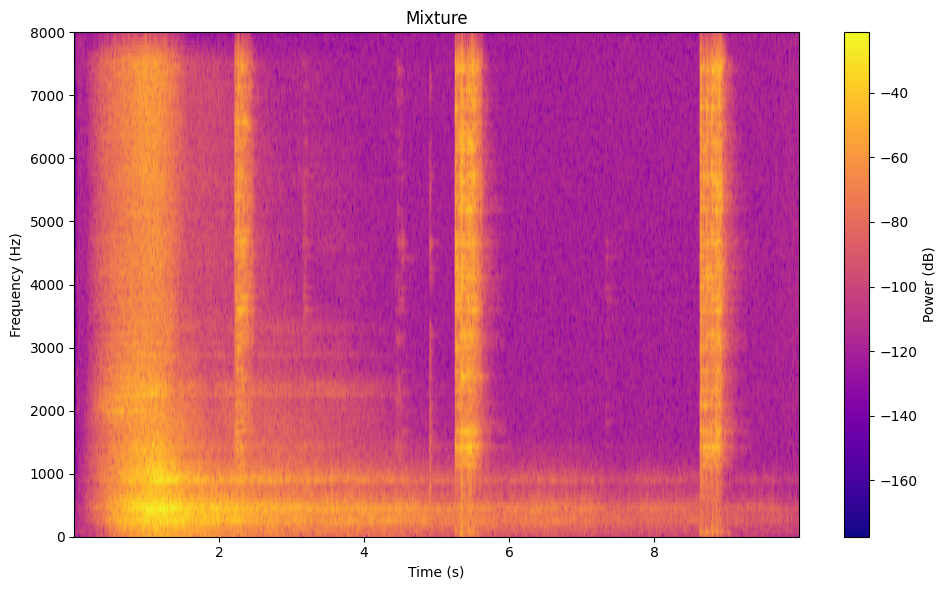

/tmp/ipykernel_622460/2839899522.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma',


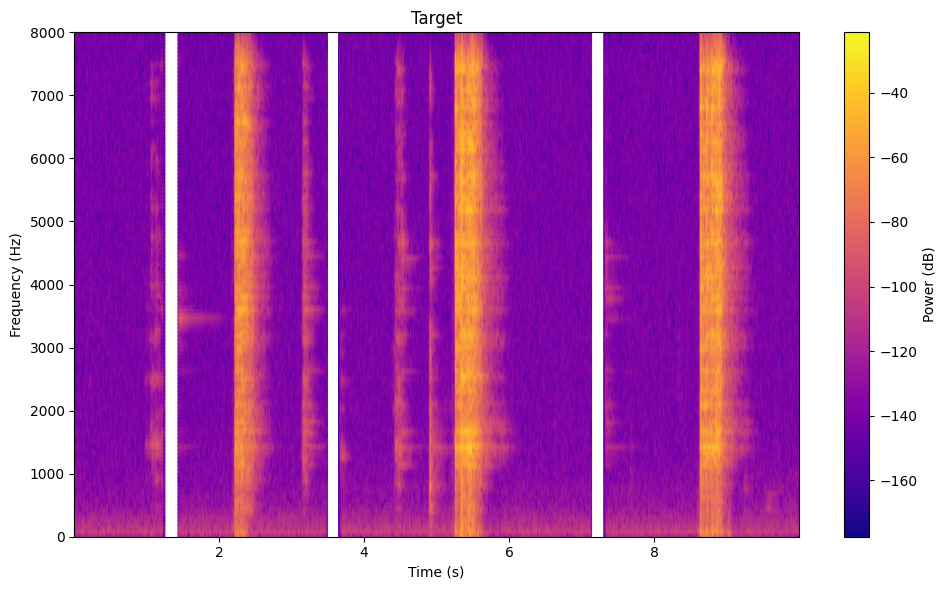

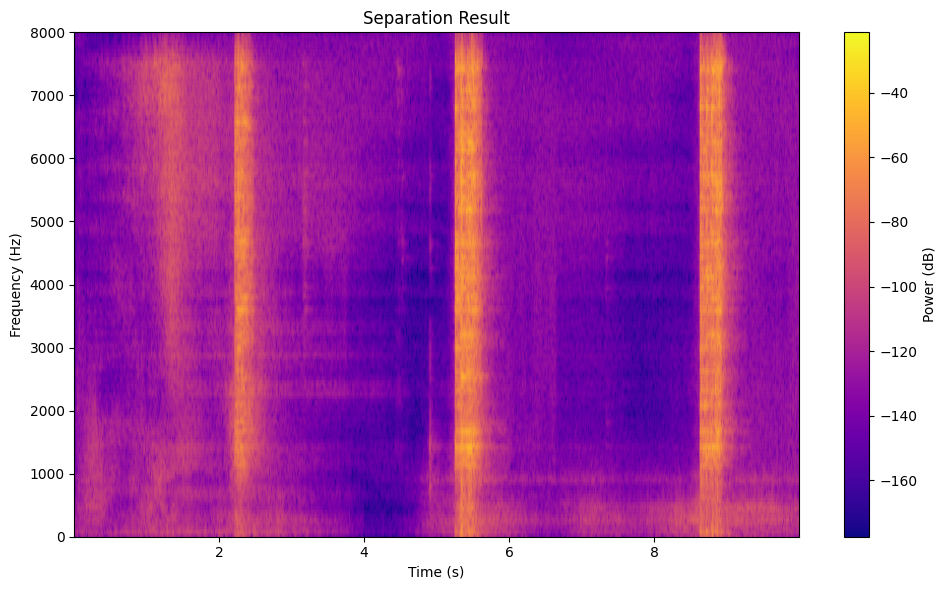

In [51]:
plot_spectrograms(mixture, source, sep_segment, sampling_rate, 'best_val_sdri')

In [54]:
df_results_parsed.sort_values(by = 'sisdr', ascending=False)[:2]

source_path  \
2717  lass_validation/688735_10403690-hq.wav   
523   lass_validation/699186_15162327-hq.wav   

                                 noise_path  \
2717  lass_validation/687039_2448533-hq.wav   
523   lass_validation/713910_4725336-hq.wav   

                                                                                input_path  \
2717  lass_validation_output/('688735_10403690-hq.wav', '687039_2448533-hq.wav')_input.wav   
523   lass_validation_output/('699186_15162327-hq.wav', '713910_4725336-hq.wav')_input.wav   

                                                                                output_path  \
2717  lass_validation_output/('688735_10403690-hq.wav', '687039_2448533-hq.wav')_output.wav   
523   lass_validation_output/('699186_15162327-hq.wav', '713910_4725336-hq.wav')_output.wav   

      input_similarity  output_similarity      sisdr       sdri        sdr  
2717          0.294499           0.523779  34.953394  32.872442  34.872441  
523           0.385054           0.464489  31.692014  24.687647  31.687647

In [52]:
source_path = df_results_parsed.sort_values(by = 'sisdr', ascending=False).iloc[0].source_path
mixture_path = df_results_parsed.sort_values(by = 'sisdr', ascending=False).iloc[0].input_path
sep_path = df_results_parsed.sort_values(by = 'sisdr', ascending=False).iloc[0].output_path

mixture, fs = librosa.load(mixture_path, sr=sampling_rate, mono=True)
source, fs = librosa.load(source_path, sr=sampling_rate, mono=True)
sep_segment, fs = librosa.load(sep_path, sr=sampling_rate, mono=True)

/tmp/ipykernel_622460/2839899522.py:14: RuntimeWarning: divide by zero encountered in log10
  source_cmesh = plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma')


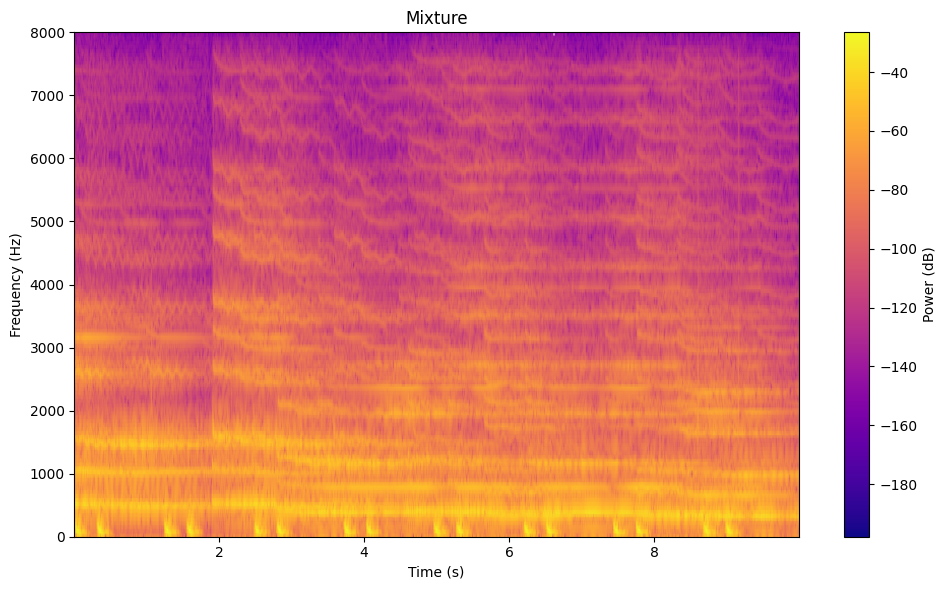

/tmp/ipykernel_622460/2839899522.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma',


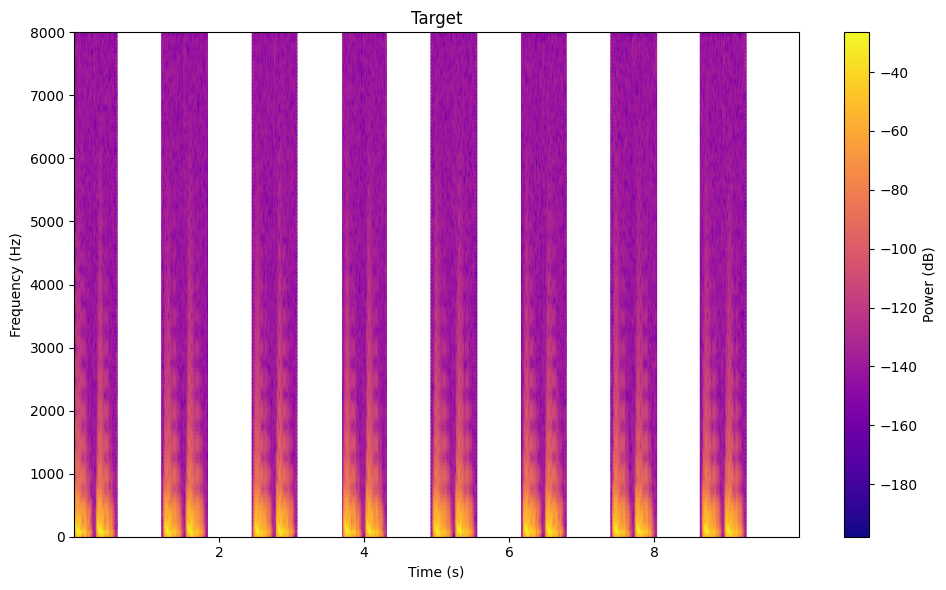

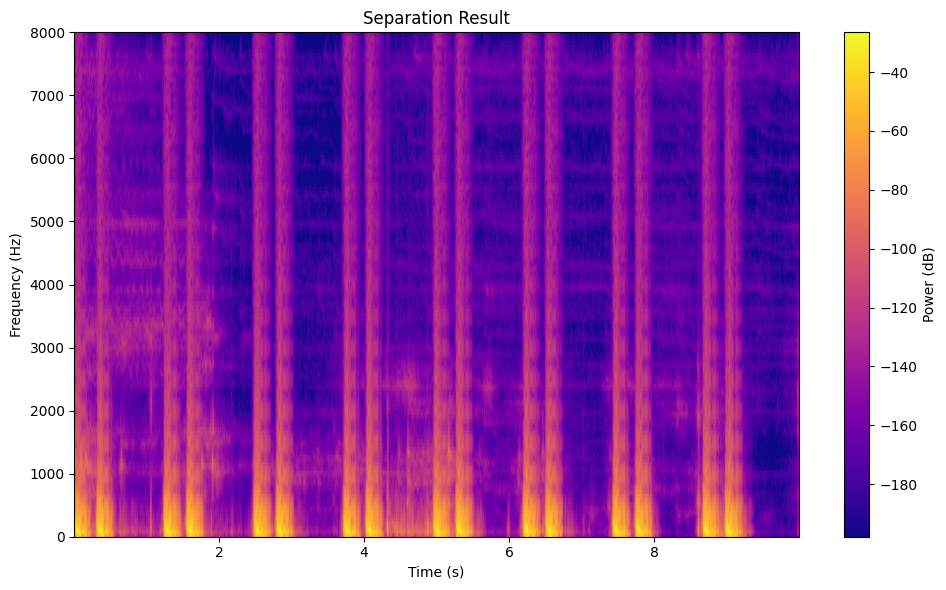

In [ ]:
# also the hearbeat
plot_spectrograms(mixture, source, sep_segment, sampling_rate, 'best_val_sisdr')

In [55]:
df_results_parsed.sort_values(by = 'input_similarity', ascending=False)[:2]

source_path  \
98  lass_validation/708900_15370659-hq.wav   
96  lass_validation/708900_15370659-hq.wav   

                                noise_path  \
98   lass_validation/699153_6196057-hq.wav   
96  lass_validation/703675_15220010-hq.wav   

                                                                               input_path  \
98   lass_validation_output/('708900_15370659-hq.wav', '699153_6196057-hq.wav')_input.wav   
96  lass_validation_output/('708900_15370659-hq.wav', '703675_15220010-hq.wav')_input.wav   

                                                                               output_path  \
98   lass_validation_output/('708900_15370659-hq.wav', '699153_6196057-hq.wav')_output.wav   
96  lass_validation_output/('708900_15370659-hq.wav', '703675_15220010-hq.wav')_output.wav   

    input_similarity  output_similarity     sisdr      sdri       sdr  
98          0.634053           0.585121  7.020782  9.340067  7.340066  
96          0.627815           0.694286  9.118333  4.616636  9.616636

In [56]:
df_results_parsed['delta_similarity'] = df_results_parsed['output_similarity'] - df_results_parsed['input_similarity']

In [57]:
df_results_parsed.sort_values(by = 'delta_similarity', ascending=False)[:2]

source_path  \
986  lass_validation/694373_2578040-hq.wav   
333  lass_validation/685293_3797507-hq.wav   

                                noise_path  \
986  lass_validation/707282_1661766-hq.wav   
333  lass_validation/688742_6525386-hq.wav   

                                                                              input_path  \
986  lass_validation_output/('694373_2578040-hq.wav', '707282_1661766-hq.wav')_input.wav   
333  lass_validation_output/('685293_3797507-hq.wav', '688742_6525386-hq.wav')_input.wav   

                                                                              output_path  \
986  lass_validation_output/('694373_2578040-hq.wav', '707282_1661766-hq.wav')_output.wav   
333  lass_validation_output/('685293_3797507-hq.wav', '688742_6525386-hq.wav')_output.wav   

     input_similarity  output_similarity     sisdr       sdri       sdr  \
986         -0.098684           0.457966 -2.399163  10.019444  0.019445   
333         -0.063349           0.484656 -5.389640   8.980265  0.980264   

     delta_similarity  
986          0.556650  
333          0.548005

In [ ]:
# Fireworks are shot into the air with swirling sounds and then they explode.